## Extension of the 5% pool for all tracers

In [1]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import seaborn as sns
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

import matplotlib.gridspec as gspec

import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set_context('notebook')
sns.set_style('white')

In [3]:
# Grid, state and tracers datasets of base case
grid_file = '/data/kramosmu/results/TracerExperiments/BARKLEY/run01/gridGlob.nc'

grid_fileNoC = '/data/kramosmu/results/TracerExperiments/BARKLEY/run02/gridGlob.nc'

state_file = '/data/kramosmu/results/TracerExperiments/BARKLEY/run01/stateGlob.nc' 

ptracers_file = '/data/kramosmu/results/TracerExperiments/BARKLEY/run01/ptracersGlob.nc'

ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/BARKLEY/run02/ptracersGlob.nc'

In [4]:
with Dataset(grid_file, 'r') as nbl:
    Z = nbl.variables['RC'][:]
    X = nbl.variables['X'][:]
    Y = nbl.variables['Y'][:]
    hFacC = nbl.variables['HFacC'][:]
    rA = nbl.variables['rA'][:]
    Depth = nbl.variables['Depth'][:]

hfac = np.ma.masked_values(hFacC, 0)
maskC = np.ma.getmask(hfac)

with Dataset(grid_fileNoC, 'r') as nbl:
    hFacCNoC = nbl.variables['HFacC'][:]

hfac = np.ma.masked_values(hFacCNoC, 0)
maskCNoC = np.ma.getmask(hfac)
 

with Dataset(state_file, 'r') as nbl:
    iters = nbl.variables['iter'][:]
 

In [103]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def ConcAreaPool(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            if TrBottom > 0.0:
                ConcArea[i,j] = TrBottom*ra[i,j]
                Conc[i,j] = TrBottom
                Area[i,j] = ra[i,j]
            else:
                ConcArea[i,j] = np.NaN
                Conc[i,j] = np.NaN
                Area[i,j] = np.NaN
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def BottomConc(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def PlotPool(ax,ConcFilt,xslice,yslice,col):
    
    ax.axvline(X[xind_CS]/1000, color = '0.5', linestyle = '-', linewidth = 1)
    ax.axhline(Y[yind_AS]/1000, color = '0.5', linestyle = '-', linewidth = 1)
    
    BAC = ConcFilt[yslice,xslice]
    
    mesh = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[0.05], 
                      colors=col, 
                      )
    
    
    mesh = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[-0.05], 
                      colors=col, 
                      )
    
    SB = ax.contour(X[xslice]/1000,Y[yslice]/1000,
                    Depth[yslice,xslice],
                    [150.0],
                    colors='0.1',linewidths=[0.75] )
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    
def PlotAS(ax,Conc,xsl,zsl,col):
    print(np.shape(X[xsl]/1000),np.shape(Z[zsl]), np.shape(Conc))
   
    mesh = ax.contour(X[xsl]/1000,Z[zsl],Conc,[0.05], 
                      colors=col, 
                      )
    mesh = ax.contour(X[xsl]/1000,Z[zsl],Conc,[-0.05], 
                      colors=col, 
                      )
    
    ax.plot(X[xsl]/1000,-Depth[yind_AS,xsl],
           '-',
           color='0.5',
           linewidth=2,
           )
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    
def PlotCS(ax,Conc,yslice,zslice,col):
    
    mesh = ax.contour(Y[yslice]/1000,Z[zslice],Conc,[0.05], 
                      colors=col, 
                      )
    mesh = ax.contour(Y[yslice]/1000,Z[zslice],Conc,[-0.05], 
                      colors=col, 
                      )
    
    ax.plot(Y[yslice]/1000,-Depth[yslice_CS, xind_CS],
           '-',
           color='0.5',
           linewidth=2,
           )
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
        
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)

In [6]:
# General input
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 
yind_AS = 275
xind_CS = 260

xslice_AS = slice(120,500)
yslice_CS = slice(227,360)
zslice_AS = slice(0,30)

yslice = slice(225,360)
xslice = slice(120,500)

tracer_names = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08']
colours = ['dark lavender','ocean blue','kelly green','cherry red','tangerine','golden yellow','medium pink','turquoise']


In [7]:
ConcFilt1 = np.ma.empty((360,616)) 
ConcFilt2 = np.ma.empty((360,616))
ConcFilt3 = np.ma.empty((360,616))
ConcFilt4 = np.ma.empty((360,616))
ConcFilt5 = np.ma.empty((360,616))
ConcFilt6 = np.ma.empty((360,616))
ConcFilt7 = np.ma.empty((360,616))
ConcFilt8 = np.ma.empty((360,616))

ConcAS1 = np.ma.empty((30,len(X[xslice_AS]))) 
ConcAS2 = np.ma.empty((30,len(X[xslice_AS])))
ConcAS3 = np.ma.empty((30,len(X[xslice_AS])))
ConcAS4 = np.ma.empty((30,len(X[xslice_AS])))
ConcAS5 = np.ma.empty((30,len(X[xslice_AS])))
ConcAS6 = np.ma.empty((30,len(X[xslice_AS])))
ConcAS7 = np.ma.empty((30,len(X[xslice_AS])))
ConcAS8 = np.ma.empty((30,len(X[xslice_AS])))

ConcCS1 = np.ma.empty((30,len(Y[yslice_CS]))) 
ConcCS2 = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS3 = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS4 = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS5 = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS6 = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS7 = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS8 = np.ma.empty((30,len(Y[yslice_CS])))

concList = [ConcFilt1,ConcFilt2,ConcFilt3,ConcFilt4,ConcFilt5,ConcFilt6,ConcFilt7,ConcFilt8]
concASList = [ConcAS1,ConcAS2,ConcAS3,ConcAS4,ConcAS5,ConcAS6,ConcAS7,ConcAS8]
concCSList = [ConcCS1,ConcCS2,ConcCS3,ConcCS4,ConcCS5,ConcCS6,ConcCS7,ConcCS8]

for trac,conc, concAS, concCS in zip(tracer_names, concList, concASList, concCSList):
    with Dataset(ptracers_file, 'r') as nbl:
        ConcArea, conc[:,:], Area = BottomConc(np.mean(nbl.variables[trac][8:18,:,:,:], axis=0),hFacC,rA,Depth)
        concAS[:,:] = np.ma.array(np.nanmean(nbl.variables[trac][8:18,zslice_AS,yind_AS,xslice_AS],0),
                                  mask=maskCNoC[zslice_AS,yind_AS,xslice_AS])
        concCS[:,:] = np.ma.array(np.nanmean(nbl.variables[trac][8:18,zslice_AS,yslice_CS,xind_CS],0),
                                  mask=maskCNoC[zslice_AS,yslice_CS,xind_CS])
       
    print('done with tracer %s' %trac )

done with tracer Tr01
done with tracer Tr02
done with tracer Tr03
done with tracer Tr04
done with tracer Tr05
done with tracer Tr06
done with tracer Tr07
done with tracer Tr08


In [8]:
Conc0Filt1 = np.ma.empty((360,616)) # saving 3 time outputs, ny,nx
Conc0Filt2 = np.ma.empty((360,616))
Conc0Filt3 = np.ma.empty((360,616))
Conc0Filt4 = np.ma.empty((360,616))
Conc0Filt5 = np.ma.empty((360,616))
Conc0Filt6 = np.ma.empty((360,616))
Conc0Filt7 = np.ma.empty((360,616))
Conc0Filt8 = np.ma.empty((360,616))

Conc0AS1 = np.ma.empty((30,len(X[xslice_AS]))) 
Conc0AS2 = np.ma.empty((30,len(X[xslice_AS])))
Conc0AS3 = np.ma.empty((30,len(X[xslice_AS])))
Conc0AS4 = np.ma.empty((30,len(X[xslice_AS])))
Conc0AS5 = np.ma.empty((30,len(X[xslice_AS])))
Conc0AS6 = np.ma.empty((30,len(X[xslice_AS])))
Conc0AS7 = np.ma.empty((30,len(X[xslice_AS])))
Conc0AS8 = np.ma.empty((30,len(X[xslice_AS])))

Conc0CS1 = np.ma.empty((30,len(Y[yslice_CS]))) 
Conc0CS2 = np.ma.empty((30,len(Y[yslice_CS])))
Conc0CS3 = np.ma.empty((30,len(Y[yslice_CS])))
Conc0CS4 = np.ma.empty((30,len(Y[yslice_CS])))
Conc0CS5 = np.ma.empty((30,len(Y[yslice_CS])))
Conc0CS6 = np.ma.empty((30,len(Y[yslice_CS])))
Conc0CS7 = np.ma.empty((30,len(Y[yslice_CS])))
Conc0CS8 = np.ma.empty((30,len(Y[yslice_CS])))

concList = [Conc0Filt1,Conc0Filt2,Conc0Filt3,Conc0Filt4,Conc0Filt5,Conc0Filt6,Conc0Filt7,Conc0Filt8]
concASList = [Conc0AS1,Conc0AS2,Conc0AS3,Conc0AS4,Conc0AS5,Conc0AS6,Conc0AS7,Conc0AS8]
concCSList = [Conc0CS1,Conc0CS2,Conc0CS3,Conc0CS4,Conc0CS5,Conc0CS6,Conc0CS7,Conc0CS8]

for trac,conc, concAS, concCS in zip(tracer_names, concList, concASList, concCSList):
    with Dataset(ptracers_file, 'r') as nbl:
        ConcArea, conc[:,:], Area = BottomConc(nbl.variables[trac][0,:,:,:],hFacC,rA,Depth)
        concAS[:,:] = np.ma.array(nbl.variables[trac][0,zslice_AS,yind_AS,xslice_AS],
                                  mask=maskCNoC[zslice_AS,yind_AS,xslice_AS])
        concCS[:,:] = np.ma.array(nbl.variables[trac][0,zslice_AS,yslice_CS,xind_CS],
                                  mask=maskCNoC[zslice_AS,yslice_CS,xind_CS])
       
    print('done with tracer %s' %trac )

done with tracer Tr01
done with tracer Tr02
done with tracer Tr03
done with tracer Tr04
done with tracer Tr05
done with tracer Tr06
done with tracer Tr07
done with tracer Tr08


In [9]:
ConcFilt1Anom = np.ma.empty((360,616)) # saving 3 time outputs, nx,ny
ConcFilt2Anom = np.ma.empty((360,616))
ConcFilt3Anom = np.ma.empty((360,616))
ConcFilt4Anom = np.ma.empty((360,616))
ConcFilt5Anom = np.ma.empty((360,616))
ConcFilt6Anom = np.ma.empty((360,616))
ConcFilt7Anom = np.ma.empty((360,616))
ConcFilt8Anom = np.ma.empty((360,616))

ConcAS1Anom = np.ma.empty((30,len(X[xslice_AS]))) 
ConcAS2Anom = np.ma.empty((30,len(X[xslice_AS])))
ConcAS3Anom = np.ma.empty((30,len(X[xslice_AS])))
ConcAS4Anom = np.ma.empty((30,len(X[xslice_AS])))
ConcAS5Anom = np.ma.empty((30,len(X[xslice_AS])))
ConcAS6Anom = np.ma.empty((30,len(X[xslice_AS])))
ConcAS7Anom = np.ma.empty((30,len(X[xslice_AS])))
ConcAS8Anom = np.ma.empty((30,len(X[xslice_AS])))

ConcCS1Anom = np.ma.empty((30,len(Y[yslice_CS]))) 
ConcCS2Anom = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS3Anom = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS4Anom = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS5Anom = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS6Anom = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS7Anom = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS8Anom = np.ma.empty((30,len(Y[yslice_CS])))

concList = [ConcFilt1Anom,ConcFilt2Anom,ConcFilt3Anom,ConcFilt4Anom,
            ConcFilt5Anom,ConcFilt6Anom,ConcFilt7Anom,ConcFilt8Anom]
concASList = [ConcAS1Anom,ConcAS2Anom,ConcAS3Anom,ConcAS4Anom,
              ConcAS5Anom,ConcAS6Anom,ConcAS7Anom,ConcAS8Anom]
concCSList = [ConcCS1Anom,ConcCS2Anom,ConcCS3Anom,ConcCS4Anom,ConcCS5Anom,ConcCS6Anom,ConcCS7Anom,ConcCS8Anom]


for trac,conc, concAS, concCS in zip(tracer_names, concList, concASList, concCSList):
    with Dataset(ptracers_file, 'r') as nbl:
        with Dataset(ptracers_fileNoC, 'r') as noc:
            ConcArea, conc[:,:], Area = BottomConc(np.nanmean(nbl.variables[trac][8:18,:,:,:]-
                                                              noc.variables[trac][8:18,:,:,:],axis=0),hFacC,rA,Depth)
            concAS[:,:] = np.ma.array(np.nanmean(nbl.variables[trac][8:18,zslice_AS,yind_AS,xslice_AS]-
                                                 noc.variables[trac][8:18,zslice_AS,yind_AS,xslice_AS],0),
                                      mask=maskCNoC[zslice_AS,yind_AS,xslice_AS])
            concCS[:,:] = np.ma.array(np.nanmean(nbl.variables[trac][8:18,zslice_AS,yslice_CS,xind_CS]-
                                                 noc.variables[trac][8:18,zslice_AS,yslice_CS,xind_CS],0),
                                      mask=maskCNoC[zslice_AS,yslice_CS,xind_CS])
       
       
    print('done with tracer %s' %trac )

done with tracer Tr01
done with tracer Tr02
done with tracer Tr03
done with tracer Tr04
done with tracer Tr05
done with tracer Tr06
done with tracer Tr07
done with tracer Tr08


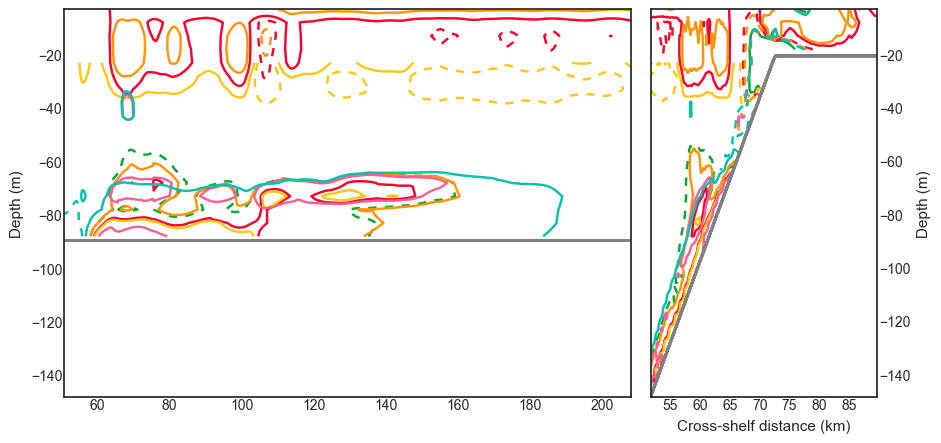

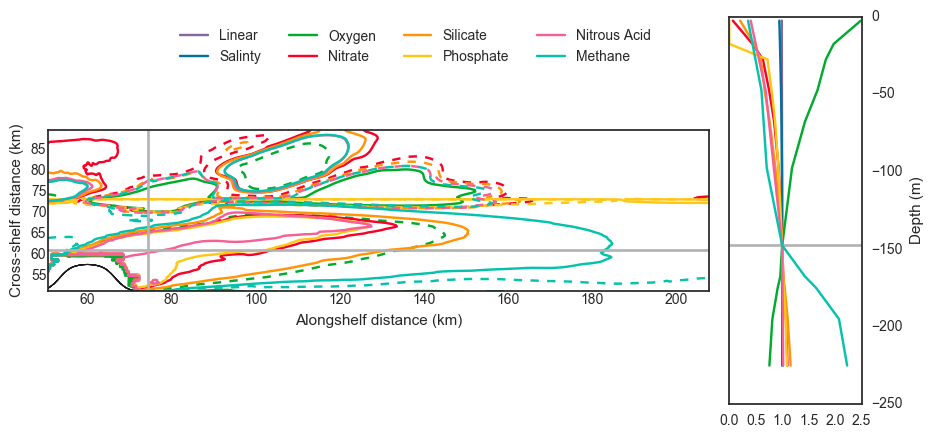

In [10]:
f = plt.figure(figsize = (10.5,5.0)) # 19.0cm = 7.4in, 115cm = 4.52in

gs = gspec.GridSpec(1, 2, width_ratios=[1,0.4], wspace=0.05, hspace=0.05 )

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

f1 = plt.figure(figsize = (10.5,5.0)) # 19.0cm = 7.4in, 115cm = 4.52in

gs2 = gspec.GridSpec(1, 2,  width_ratios=[1,0.2], wspace=0.05, hspace=0.05 )

ax2 = plt.subplot(gs2[0])
ax3 = plt.subplot(gs2[1])

ii = 0    

PlotPool(ax2,(ConcFilt1Anom[:,:])/Conc0Filt1,xslice,yslice,col=sns.xkcd_rgb[colours[0]])
PlotPool(ax2,(ConcFilt2Anom[:,:])/Conc0Filt2,xslice,yslice,col=sns.xkcd_rgb[colours[1]])
PlotPool(ax2,(ConcFilt3Anom[:,:])/Conc0Filt3,xslice,yslice,col=sns.xkcd_rgb[colours[2]])
PlotPool(ax2,(ConcFilt4Anom[:,:])/Conc0Filt4,xslice,yslice,col=sns.xkcd_rgb[colours[3]])
PlotPool(ax2,(ConcFilt5Anom[:,:])/Conc0Filt5,xslice,yslice,col=sns.xkcd_rgb[colours[4]])
PlotPool(ax2,(ConcFilt6Anom[:,:])/Conc0Filt6,xslice,yslice,col=sns.xkcd_rgb[colours[5]])
PlotPool(ax2,(ConcFilt7Anom[:,:])/Conc0Filt7,xslice,yslice,col=sns.xkcd_rgb[colours[6]])
PlotPool(ax2,(ConcFilt8Anom[:,:])/Conc0Filt8,xslice,yslice,col=sns.xkcd_rgb[colours[7]])

PlotAS(ax0,(ConcAS1Anom[:,:]/Conc0AS1),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[0]])
PlotAS(ax0,(ConcAS2Anom[:,:]/Conc0AS2),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[1]])
PlotAS(ax0,(ConcAS3Anom[:,:]/Conc0AS3),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[2]])
PlotAS(ax0,(ConcAS4Anom[:,:]/Conc0AS4),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[3]])
PlotAS(ax0,(ConcAS5Anom[:,:]/Conc0AS5),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[4]])
PlotAS(ax0,(ConcAS6Anom[:,:]/Conc0AS6),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[5]])
PlotAS(ax0,(ConcAS7Anom[:,:]/Conc0AS7),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[6]])
PlotAS(ax0,(ConcAS8Anom[:,:]/Conc0AS8),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[7]])
 
PlotCS(ax1,(ConcCS1Anom[:,:]/Conc0CS1[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[0]])
PlotCS(ax1,(ConcCS2Anom[:,:]/Conc0CS2[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[1]])
PlotCS(ax1,(ConcCS3Anom[:,:]/Conc0CS3[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[2]])
PlotCS(ax1,(ConcCS4Anom[:,:]/Conc0CS4[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[3]])
PlotCS(ax1,(ConcCS5Anom[:,:]/Conc0CS5[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[4]])
PlotCS(ax1,(ConcCS6Anom[:,:]/Conc0CS6[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[5]])
PlotCS(ax1,(ConcCS7Anom[:,:]/Conc0CS7[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[6]])
PlotCS(ax1,(ConcCS8Anom[:,:]/Conc0CS8[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[7]])

tracer_legend = ['Linear','Salinty','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Acid','Methane']
with Dataset(ptracers_file, 'r') as nbl:
    for trac, ii, lab in zip(tracer_names, range(len(tracer_names)), tracer_legend):
        ax3.axhline(Z[29], color='0.7', linewidth=1)
        profile = nbl.variables[trac][0,0:40,50,180]
        C0 = profile[29]
        ax3.plot(profile/C0,Z[0:40],color=sns.xkcd_rgb[colours[ii]], label=lab)
        ax3.yaxis.tick_right()
        ax3.yaxis.set_label_position("right")
        ax3.set_ylabel('Depth (m)')

ax0.set_ylabel('Depth (m)')
ax2.set_xlabel('Alongshelf distance (km)')
ax2.set_ylabel('Cross-shelf distance (km)')
ax1.set_xlabel('Cross-shelf distance (km)')
ax1.set_ylabel('Depth (m)')

ax3.legend(ncol=4, bbox_to_anchor=(-0.5,1) )


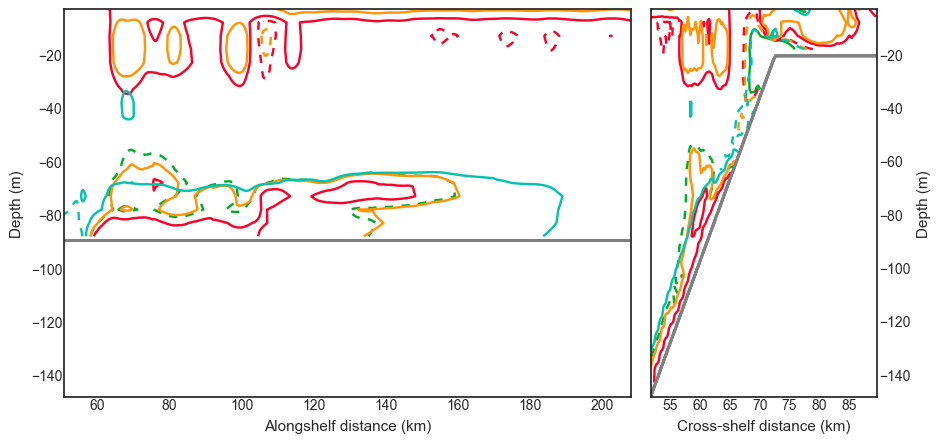

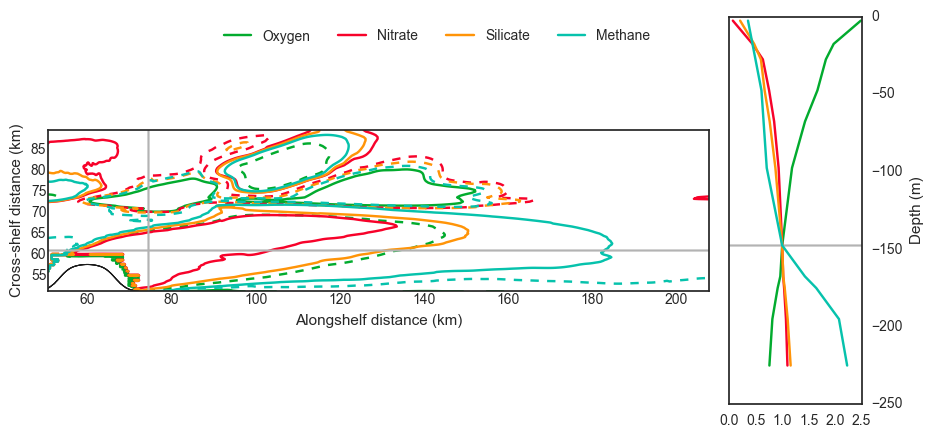

In [11]:
f1 = plt.figure(figsize = (10.5,5)) # 19.0cm = 7.4in, 115cm = 4.52in

gs = gspec.GridSpec(1, 2, width_ratios=[1,0.4], wspace=0.05, hspace=0.05 )

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

f1 = plt.figure(figsize = (10.5,5.0)) # 19.0cm = 7.4in, 115cm = 4.52in

gs2 = gspec.GridSpec(1, 2,  width_ratios=[1,0.2], wspace=0.05, hspace=0.05 )

ax2 = plt.subplot(gs2[0])
ax3 = plt.subplot(gs2[1])

ii = 0    

PlotPool(ax2,(ConcFilt3Anom[:,:])/Conc0Filt3,xslice,yslice,col=sns.xkcd_rgb[colours[2]])
PlotPool(ax2,(ConcFilt4Anom[:,:])/Conc0Filt4,xslice,yslice,col=sns.xkcd_rgb[colours[3]])
PlotPool(ax2,(ConcFilt5Anom[:,:])/Conc0Filt5,xslice,yslice,col=sns.xkcd_rgb[colours[4]])
PlotPool(ax2,(ConcFilt8Anom[:,:])/Conc0Filt8,xslice,yslice,col=sns.xkcd_rgb[colours[7]])

PlotAS(ax0,(ConcAS3Anom[:,:]/Conc0AS3),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[2]])
PlotAS(ax0,(ConcAS4Anom[:,:]/Conc0AS4),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[3]])
PlotAS(ax0,(ConcAS5Anom[:,:]/Conc0AS5),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[4]])
PlotAS(ax0,(ConcAS8Anom[:,:]/Conc0AS8),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[7]])
 
PlotCS(ax1,(ConcCS3Anom[:,:]/Conc0CS3[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[2]])
PlotCS(ax1,(ConcCS4Anom[:,:]/Conc0CS4[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[3]])
PlotCS(ax1,(ConcCS5Anom[:,:]/Conc0CS5[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[4]])
PlotCS(ax1,(ConcCS8Anom[:,:]/Conc0CS8[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[7]])

tracer_names_2 = ['Tr03', 'Tr04', 'Tr05', 'Tr08']
tracer_legend_2 = ['Oxygen','Nitrate','Silicate','Methane']

with Dataset(ptracers_file, 'r') as nbl:
    for trac, ii, lab in zip(tracer_names_2, [2,3,4,7], tracer_legend_2):
        ax3.axhline(Z[29], color='0.7', linewidth=1)
        profile = nbl.variables[trac][0,0:40,50,180]
        C0 = profile[29]
        ax3.plot(profile/C0,Z[0:40],color=sns.xkcd_rgb[colours[ii]], label=lab)
        ax3.yaxis.tick_right()
        ax3.yaxis.set_label_position("right")
        ax3.set_ylabel('Depth (m)')

ax0.set_ylabel('Depth (m)')
ax2.set_xlabel('Alongshelf distance (km)')
ax0.set_xlabel('Alongshelf distance (km)')

ax2.set_ylabel('Cross-shelf distance (km)')
ax1.set_xlabel('Cross-shelf distance (km)')
ax1.set_ylabel('Depth (m)')

ax3.legend(ncol=4, bbox_to_anchor=(-0.5,1) )



(380,) (10,) (10, 380)
(380,) (10,) (10, 380)
(380,) (10,) (10, 380)
(380,) (10,) (10, 380)


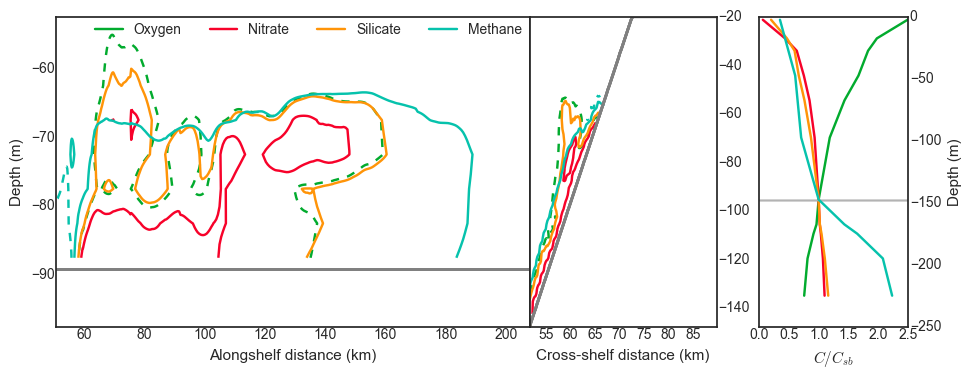

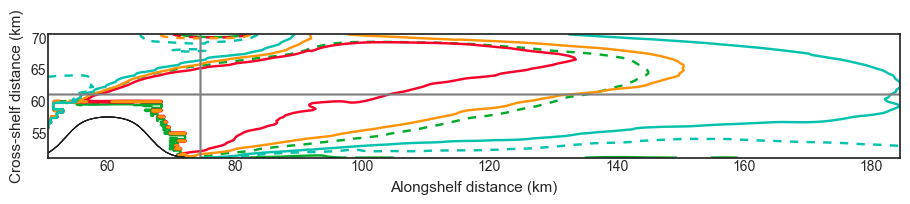

In [193]:
yslice2 = slice(225,310)
xslice2 = slice(120,463)
zslice_AS2 = slice(10,20)
zslice_CS2 = slice(10,30)

f1 = plt.figure(figsize = (11,4)) # 19.0cm = 7.4in, 115cm = 4.52in

gs = gspec.GridSpec(1, 2, width_ratios=[1, 0.8], wspace=0.0, hspace=0.05 )
gs0 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1],width_ratios=[1,0.8], wspace=0.25)

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs0[0])
ax3 = plt.subplot(gs0[1])

f2, ax2 = plt.subplots(1,1,figsize = (11,4.0)) # 19.0cm = 7.4in, 115cm = 4.52in

ii = 0    

PlotPool(ax2,(ConcFilt3Anom[:,:])/Conc0Filt3,xslice2,yslice2,col=sns.xkcd_rgb[colours[2]])
PlotPool(ax2,(ConcFilt4Anom[:,:])/Conc0Filt4,xslice2,yslice2,col=sns.xkcd_rgb[colours[3]])
PlotPool(ax2,(ConcFilt5Anom[:,:])/Conc0Filt5,xslice2,yslice2,col=sns.xkcd_rgb[colours[4]])
PlotPool(ax2,(ConcFilt8Anom[:,:])/Conc0Filt8,xslice2,yslice2,col=sns.xkcd_rgb[colours[7]])

PlotAS(ax0,(ConcAS3Anom[zslice_AS2, :]/Conc0AS3[zslice_AS2, :]),xslice_AS,zslice_AS2,col=sns.xkcd_rgb[colours[2]])
PlotAS(ax0,(ConcAS4Anom[zslice_AS2, :]/Conc0AS4[zslice_AS2, :]),xslice_AS,zslice_AS2,col=sns.xkcd_rgb[colours[3]])
PlotAS(ax0,(ConcAS5Anom[zslice_AS2, :]/Conc0AS5[zslice_AS2, :]),xslice_AS,zslice_AS2,col=sns.xkcd_rgb[colours[4]])
PlotAS(ax0,(ConcAS8Anom[zslice_AS2, :]/Conc0AS8[zslice_AS2, :]),xslice_AS,zslice_AS2,col=sns.xkcd_rgb[colours[7]])
 
PlotCS(ax1,(ConcCS3Anom[zslice_CS2,:]/Conc0CS3[zslice_CS2,:]),yslice_CS,zslice_CS2,col=sns.xkcd_rgb[colours[2]])
PlotCS(ax1,(ConcCS4Anom[zslice_CS2,:]/Conc0CS4[zslice_CS2,:]),yslice_CS,zslice_CS2,col=sns.xkcd_rgb[colours[3]])
PlotCS(ax1,(ConcCS5Anom[zslice_CS2,:]/Conc0CS5[zslice_CS2,:]),yslice_CS,zslice_CS2,col=sns.xkcd_rgb[colours[4]])
PlotCS(ax1,(ConcCS8Anom[zslice_CS2,:]/Conc0CS8[zslice_CS2,:]),yslice_CS,zslice_CS2,col=sns.xkcd_rgb[colours[7]])

tracer_names_2 = ['Tr03', 'Tr04', 'Tr05', 'Tr08']
tracer_legend_2 = ['Oxygen','Nitrate','Silicate','Methane']

with Dataset(ptracers_file, 'r') as nbl:
    for trac, ii, lab in zip(tracer_names_2, [2,3,4,7], tracer_legend_2):
        ax3.axhline(Z[29], color='0.7', linewidth=1)
        profile = nbl.variables[trac][0,0:40,50,180]
        C0 = profile[29]
        ax3.plot(profile/C0,Z[0:40],color=sns.xkcd_rgb[colours[ii]], label=lab)
        ax3.yaxis.tick_right()
        ax3.yaxis.set_label_position("right")
        ax3.set_ylabel('Depth (m)')

ax3.tick_params(axis='x', pad=1)
ax3.tick_params(axis='y', pad=1)

ax3.set_xlabel('$C/C_{sb}$')
ax0.set_ylabel('Depth (m)')
ax2.set_xlabel('Alongshelf distance (km)')
ax0.set_xlabel('Alongshelf distance (km)')

ax2.set_ylabel('Cross-shelf distance (km)')
ax1.set_xlabel('Cross-shelf distance (km)')
#ax1.set_ylabel('Depth (m)')

ax3.legend(ncol=4, bbox_to_anchor=(-1.5,1.02) )

f1.savefig('pool_vert_5percent_O2NitSilMet.eps', format='eps',bbox_inches='tight')
f2.savefig('pool_5percent_O2NitSilMet.eps', format='eps',bbox_inches='tight')


## Bottom concentrations

In [159]:
BCA01 = np.ma.empty((nt,ny,nx))
BCA02 = np.ma.empty((nt,ny,nx))
BCA03 = np.ma.empty((nt,ny,nx))
BCA04 = np.ma.empty((nt,ny,nx))
BCA05 = np.ma.empty((nt,ny,nx))
BCA06 = np.ma.empty((nt,ny,nx))
BCA07 = np.ma.empty((nt,ny,nx))
BCA08 = np.ma.empty((nt,ny,nx))

BC01 = np.ma.empty((nt,ny,nx))
BC02 = np.ma.empty((nt,ny,nx))
BC03 = np.ma.empty((nt,ny,nx))
BC04 = np.ma.empty((nt,ny,nx))
BC05 = np.ma.empty((nt,ny,nx))
BC06 = np.ma.empty((nt,ny,nx))
BC07 = np.ma.empty((nt,ny,nx))
BC08 = np.ma.empty((nt,ny,nx))

Area01 = np.ma.empty((nt,ny,nx))
Area02 = np.ma.empty((nt,ny,nx))
Area03 = np.ma.empty((nt,ny,nx))
Area04 = np.ma.empty((nt,ny,nx))
Area05 = np.ma.empty((nt,ny,nx))
Area06 = np.ma.empty((nt,ny,nx))
Area07 = np.ma.empty((nt,ny,nx))
Area08 = np.ma.empty((nt,ny,nx))

concList = [BC01,BC02,BC03,BC04,BC05,BC06,BC07,BC08]
concListAnom = [BCA01,BCA02,BCA03,BCA04,BCA05,BCA06,BCA07,BCA08]
areaList = [Area01,Area02,Area03,Area04,Area05,Area06,Area07,Area08]

for trac,BC,BCA,Area in zip(tracer_names, concList, concListAnom, areaList):
    with Dataset(ptracers_file, 'r') as nbl:
        with Dataset(ptracers_fileNoC, 'r') as noc:
            for ii in range(nt):
                BCA[ii,:,:], dummy, AreaTot1 = BottomConc(noc.variables[trac][ii,:,:,:], hFacCNoC,rA,Depth)
                BC[ii,:,:], dummy, AreaTot2 = BottomConc(nbl.variables[trac][ii,:,:,:],hFacCNoC,rA,Depth)


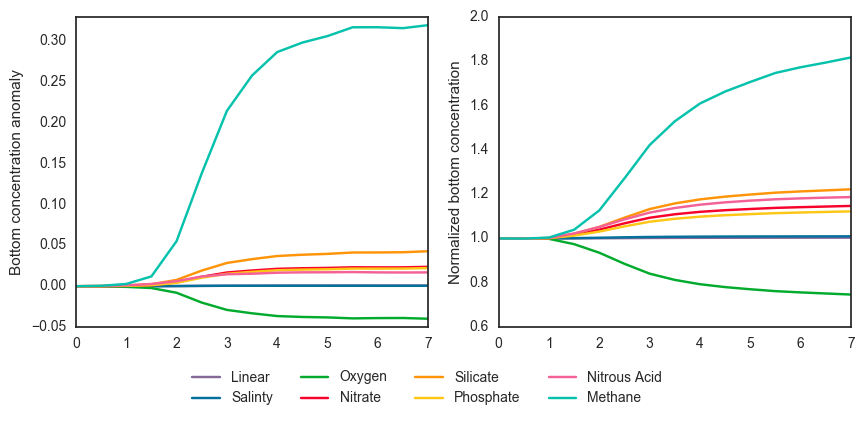

In [198]:
tracer_names_2 = ['Tr03', 'Tr04', 'Tr05', 'Tr08']
tracer_legend_2 = ['Oxygen','Nitrate','Silicate','Methane']

fig, (ax1,ax3) = plt.subplots(1,2,figsize=(10,4))

ax1.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC01[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC01[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA01[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA01[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[0]], label=tracer_legend[0])

ax1.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC02[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC02[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA02[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA02[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[1]], label=tracer_legend[1])

ax1.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC03[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC03[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA03[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA03[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[2]], label=tracer_legend[2])

ax1.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC04[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC04[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA04[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA04[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[3]], label=tracer_legend[3])

ax1.plot(np.arange(19)/2,((np.nansum(np.nansum(BC05[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC05[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA05[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA05[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[4]], label=tracer_legend[4])

ax1.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC06[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC06[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA06[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA06[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[5]], label=tracer_legend[5])

ax1.plot(np.arange(19)/2,  ((np.nansum(np.nansum(BC07[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC07[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA07[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA07[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[6]], label=tracer_legend[6])

ax1.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC08[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC08[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA08[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA08[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[7]], label=tracer_legend[7])

#ax2.plot(np.arange(19)/2, np.nansum(np.nansum(Area01[:,227:310,120:463], axis=1), axis=1), color=sns.xkcd_rgb[colours[0]])
#ax2.plot(np.arange(19)/2, np.nansum(np.nansum(Area02[:,227:310,120:463], axis=1), axis=1), color=sns.xkcd_rgb[colours[1]])
#ax2.plot(np.arange(19)/2, np.nansum(np.nansum(Area03[:,227:310,120:463], axis=1), axis=1), color=sns.xkcd_rgb[colours[2]])
#ax2.plot(np.arange(19)/2, np.nansum(np.nansum(Area04[:,227:310,120:463], axis=1), axis=1), color=sns.xkcd_rgb[colours[3]])
#ax2.plot(np.arange(19)/2, np.nansum(np.nansum(Area05[:,227:310,120:463], axis=1), axis=1), color=sns.xkcd_rgb[colours[4]])
#ax2.plot(np.arange(19)/2, np.nansum(np.nansum(Area06[:,227:310,120:463], axis=1), axis=1), color=sns.xkcd_rgb[colours[5]])
#ax2.plot(np.arange(19)/2, np.nansum(np.nansum(Area07[:,227:310,120:463], axis=1), axis=1), color=sns.xkcd_rgb[colours[6]])
#ax2.plot(np.arange(19)/2, np.nansum(np.nansum(Area08[:,227:310,120:463], axis=1), axis=1), color=sns.xkcd_rgb[colours[7]])

ax3.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC01[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC01[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[0]])

ax3.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC02[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC02[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[1]])

ax3.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC03[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC03[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[2]])

ax3.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC04[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC04[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[3]])

ax3.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC05[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC05[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[4]])

ax3.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC06[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC06[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[5]])

ax3.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC07[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC07[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[6]])

ax3.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC08[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC08[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[7]])

ax1.set_xlim(0,7)
#ax2.set_xlim(0,7)
ax3.set_xlim(0,7)

ax1.set_ylim(-0.05, 0.33)
ax1.legend(bbox_to_anchor=(1.7, -0.1), ncol=4)
ax3.set_ylabel('Normalized bottom concentration')
ax1.set_ylabel('Bottom concentration anomaly')
#ax2.set_ylabel('Area ( $10^9$ m$^2$)')
fig.savefig('bottom_conc_Barkley.eps', format='eps',bbox_inches='tight')



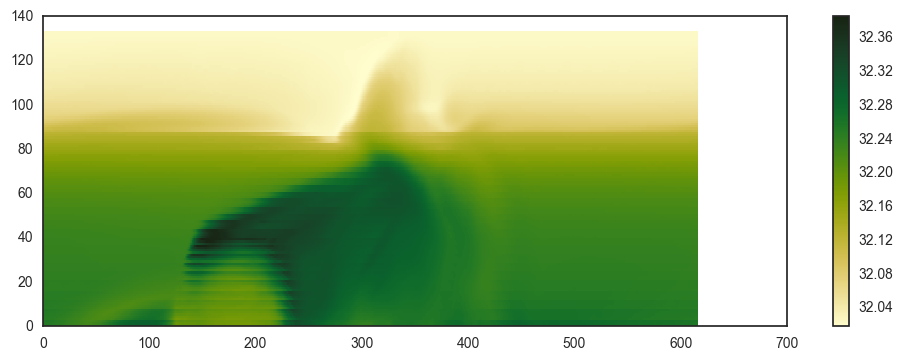

In [130]:
fig, (ax2) = plt.subplots(1,1,figsize=(12,4))

mesh = ax2.pcolor(BC01[10,227:,:]/AreaTot[227:,:], cmap=cmo.cm.speed)
cb = plt.colorbar(mesh)
